
## Music Information Retreival Project : Audio Identification 

Prepared By Rahul Agarwal, April 2018

The Project used two methods for Audio Identification : 

1. Matching through Spectral Peaks
2. Local Senstive Hashing of Audio Files 



## Audio Identification Through Spectral Peaks 

 Here we try to identify given audio samples with already present audio files in database . The identification process is based on finding the spectral peaks in both test sample and present audios files which act as identifier for that audio. We find most powerful frequencies (frequencies corrosponding to maximum amplitute) which forms spectral envelope of test audio and try to match with frequency peaks of audio present in database. 


In [54]:
from scipy import signal
import os
import sys
import numpy as np
import essentia.standard as ess
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import math

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
import urllib.request
import zipfile
import os, sys,shutil


In [68]:
#soundsDIR='../data/freesound/'
fs=44100
frameSize = 1024
windowSize = 1024
hopSize = 512
np.set_printoptions(precision=3)

''' Download the test audio file and audio files to which test audio is to be identified. 
   Two files furelise.wav and moonlight.wav has been used as existing database files.
   testAudio.wav is the file to me identified with these two files.

'audio' folder is created where all files are downloaded from url.
'''

soundsDIR='../../../data/audio'

if not os.path.exists(soundsDIR):
    #Initialization
    url='https://github.com/rahulbcn27/genreClassificationUsingML/blob/master/audio.zip?raw=true'
    filename='audio.zip'
    os.mkdir(soundsDIR)#creating the directory
    #Downloading the zip file from the url
    urllib.request.urlretrieve(url,filename)
    #print(file) 
    #Unzipping to a specific folder
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(soundsDIR)
    zip_ref.close()
    
    os.remove(filename)#Removing the zip file
    
    print('Data downloaded and unzipped to: ',soundsDIR)
else:
    print('Folder ',soundsDIR,' already exists, delete it if you want to re-download data')





Data downloaded and unzipped to:  ../../../data/audio


In [33]:
# formation of Dataset of Existing Audio files. 
SoundsDIR = '../../../data/audio/audio/'

furelise = ess.MonoLoader(filename = SoundsDIR+'./train/furelise.wav', sampleRate = fs)()
moonlight = ess.MonoLoader(filename =  SoundsDIR+'./train/moonlight.wav', sampleRate = fs)()

#User Recorded Audio samples to identify with existing audio files
testAudio = ess.MonoLoader(filename =  SoundsDIR+'testAudio.wav', sampleRate = fs)()
testAudio2 = ess.MonoLoader(filename =  SoundsDIR+'testAudio2.wav', sampleRate = fs)()

    
#pass through low pass filter to reduce noise in each of test samples

testAudio = ess.LowPass()(testAudio) 
testAudio2 = ess.LowPass()(testAudio2)

#Next lines commented to reduce notebook size on github
#ipd.Audio(testAudio, rate=fs)
#ipd.Audio(testAudio2, rate=fs)#contains little noise and little reverb for real world simulation

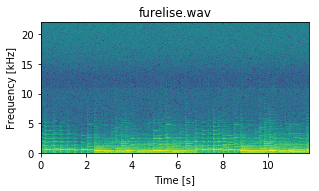

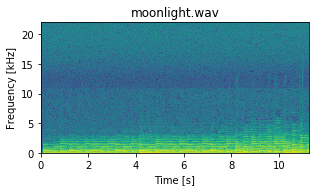

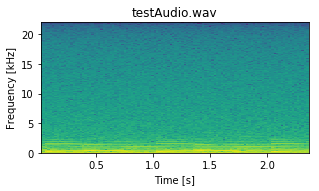

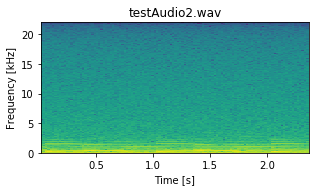

In [34]:
#Time-Frequency Spectogram of Audio Files
def getTimeFreqSpectogram(audio, fs,audioFilename):
    
    freqs, times, Sx = signal.spectrogram(audio, fs,
                                          nperseg=1024,
                                          detrend=False, scaling='spectrum')
   
    f, ax = plt.subplots(figsize=(4.8, 2.4))
    ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [s]');
    ax.set_title(audioFilename)
    
getTimeFreqSpectogram(furelise, fs,'furelise.wav')
getTimeFreqSpectogram(moonlight, fs,'moonlight.wav')
getTimeFreqSpectogram(testAudio, fs,'testAudio.wav')
getTimeFreqSpectogram(testAudio, fs,'testAudio2.wav')

In [35]:
'''
Calculation of Spectral Peaks from Audio Samples using SpectralPeaks function on every frame of given audio.
It gives back list of magnitute and corrosponding frequencies which form spectral envelope and 
identity of sound .
'''
SpecPeaks = ess.SpectralPeaks()

spectrum = ess.Spectrum(size=frameSize)

window = ess.Windowing(size=windowSize, type='hann')

def getPeaksFromAudio(audio, frameSize, hopSize):
    
    peakArray = [] #audio peak Array to calculate
    
    for frame in ess.FrameGenerator(audio, frameSize=frameSize, hopSize=hopSize, startFromZero=True):        
        magSpec = spectrum(window(frame))  #magnitute Spectrum of a frame    
        freqPeakArray, magPeakArray = SpecPeaks(magSpec)  #freqPeakArray 
        
        magPeakArray = magPeakArray.tolist()  #converting np.array to list for extracting maximum amplitute
        freqPeakArray = freqPeakArray.tolist()
        magPeakMax = max(magPeakArray)   # maximum amplitute for this frame
      
        index = magPeakArray.index(magPeakMax)    
        freqPeakMax = freqPeakArray[index]   #corrosponding max frequency for peak magnitute 
      
        peakArray.append(int(round(freqPeakMax)))  # adding max frequency to peakArray
        
    return peakArray


In [36]:
#comparison of peak frequencies of two audio samples , returns array of matched peaks

def match_array(x_Array, y_Array):
    matchCount = 0
    matchArray = []
    for y in y_Array:
        for x in x_Array:          
            if x == y:
                matchCount = matchCount +1
                matchArray.append([x,y])
    return matchCount
'''
Fixed the Bug of sequential matching of testAudio and database Audio, as it should be matched
for the whole window , not leaving error of finding peaks randomly in the Audio Array.

'''

def compareFreqlist(audio, testAudio):
    matchCountArray = []
    for i in range(0, len(audio)-len(testAudio)+1):
        matchCount = match_array(audio[i:i+len(testAudio)], testAudio)
        matchCountArray.append(matchCount)
    return max(matchCountArray)

number of peaks matched with furelise 273
number of peaks matched with moonlight 748


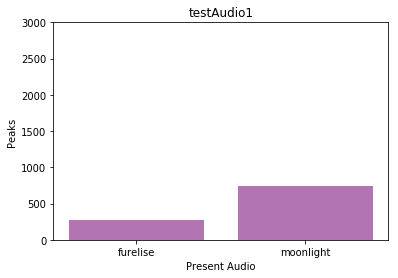

audio files identified in descending order 
moonlight.wav
furelise.wav
number of peaks matched with furelise 552
number of peaks matched with moonlight 657


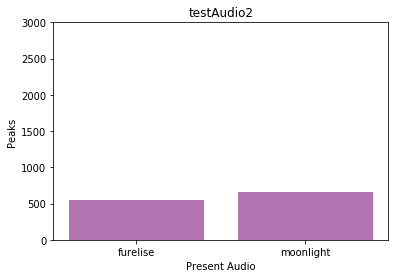

audio files identified in descending order 
moonlight.wav
furelise.wav


In [38]:
#Get Frequencies of peaks for each audio file and test sample file. 

furelise_Peaks = getPeaksFromAudio(furelise, frameSize, hopSize)
moonlight_Peaks = getPeaksFromAudio(moonlight, frameSize, hopSize)
testAudio_Peaks = getPeaksFromAudio(testAudio, frameSize, hopSize)
testAudio2_Peaks = getPeaksFromAudio(testAudio2, frameSize, hopSize)

ipd.Audio(testAudio, rate=fs)

ipd.Audio(testAudio, rate=fs)

#Match peaks of each testAudioSample with Spectral peaks frequencies of audio files.

testAudioPeaks = [testAudio_Peaks, testAudio2_Peaks]
count = 1

for testAudioPeak in testAudioPeaks:

    fureliseMatch = compareFreqlist(furelise_Peaks, testAudioPeak)
    moonlightMatch = compareFreqlist(moonlight_Peaks, testAudioPeak)
    print("number of peaks matched with furelise",fureliseMatch)
    print("number of peaks matched with moonlight",moonlightMatch)
    
    
    height = [fureliseMatch, moonlightMatch]
    bars = ('furelise', 'moonlight')
    y_pos = np.arange(len(bars))
 
    # Create bars and choose color
    plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
    # Add title and axis names
    plt.title('testAudio'+str(count))
    plt.xlabel('Present Audio')
    plt.ylabel('Peaks')
 
    # Limits for the Y axis
    plt.ylim(0,3000)
 
    # Create names
    plt.xticks(y_pos, bars)
 
    # Show graphic
    plt.show()
    
    
     
    print('audio files identified in descending order ')
    if(fureliseMatch >= moonlightMatch):    
        print('furelise')
        print('moonlight')
    else:
        print('moonlight.wav')
        print('furelise.wav')
    
    count=count+1

## Local Sensitive Hashing

Here we implement Local Sensitive Hashing to our DataSet . Locality Sensitive Hashing (LSH) is an algorithm known for enabling scalable, approximate nearest neighbor search of objects. LSH enables a precomputation of a hash that can be quickly compared with another hash to ascertain their similarity. We extract the features of files in out dataset and compute thier hash and stores in a table. Similarly, Hash is calculated for given test audio file and we match its hash with already stored hashes. I have referenced the algorithm and methods from
stevetjoa standfor mir website. 

In [ ]:
fs=44100
frameSize = 1024
windowSize = 1024
hopSize = 512
np.set_printoptions(precision=3)

In [ ]:
training_dir = '../../../data/audio/audio/train/'
training_files = [os.path.join(training_dir, f) for f in os.listdir(training_dir)]

In [ ]:
'''
define the hash function to caluclate the hash.It takes the dot product between given feature vector 
and our defined projection vector of limited size. 

'''
def hash_func(vecs, projections):
    bools = np.dot(vecs, projections.T) > 0
    return [bool2int(bool_vec) for bool_vec in bools]

def bool2int(x):
    y = 0
    for i,j in enumerate(x):
        if j: y += 1<<i
    return y

bool2int([False, True, False, True])


In [ ]:
from sklearn import preprocessing

#extract features from the audio file , preprocess it and return the feature array

def extract_features(filepath):
        
               
    # Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
    features, features_frames = ess.MusicExtractor(lowlevelStats=['mean', 'stdev'], 
                                                  rhythmStats=['mean', 'stdev'], 
                                                  tonalStats=['mean', 'stdev'])(filepath)    
    feature_dict = {}
            

    for feature in features.descriptorNames():
        if feature.find('lowlevel') != -1 or feature.find('rhythm') != -1 or feature.find('tonal') != -1:       
            if type(features[feature]) != str and type(features[feature]) != np.ndarray:
                if feature.find('mean') != -1 or feature.find('stdev') != -1:            
                    feature_dict[feature] = features[feature] 
                            
                            
    #preprocessing step.Standerdising the features
            
    feature_list = []       
            
    for value in feature_dict.values():
        feature_list.append(value)    
            
    feature_list = preprocessing.scale(feature_list)      
    
    return feature_list #return features of audio file  

In [ ]:

#Template of the Local Sensitive Hashing
class LSH:
    
    def __init__(self, dim):
        self.num_tables = 4
        self.hash_size = 8
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(self.hash_size, dim))
    
    def add(self, vecs, label):  #add feature vector to the table
        for table in self.tables:
            table.add(vecs, label)
    
    def query(self, vecs):    # query feature from the table and add to the results
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

    def describe(self):   #description of the tables
        for table in self.tables:
            print (table.table)

In [ ]:
class audioIndentification:
    
    def __init__(self, training_files):
        self.frame_size = 4096
        self.hop_size = 4000
        self.fv_size = 12
        self.lsh = LSH(self.fv_size) #intiliazing LSH object
        self.training_files = training_files  # audio file dataset to get Hashed 
        self.num_features_in_file = dict() 
        for f in self.training_files:
            self.num_features_in_file[f] = 0
                
    def train(self):
        for filepath in self.training_files:
            print(filepath)
            features = extract_features(filepath) #extracting features from the audio file

            features.resize((len(features), 12))
            
            self.lsh.add(features, filepath)  #adding featueres to Hash Table by creating thier hash
            self.num_features_in_file[filepath] += len(features)
                
    def query(self, filepath):

     #   x = ess.MonoLoader(filepath, sampleRate = fs)()
        features = extract_features(filepath)
     
        features.resize((len(features), 12))
 
        results = self.lsh.query(features)  #Query the features from the Local Hash Table
        print ('num results', len(results))

        counts = dict()
        for r in results:
            if r['label'] in counts:
                counts[r['label']] += 1
            else:
                counts[r['label']] = 1
        for k in counts:
            counts[k]

In [ ]:

#Doing the Local Sensitive Hashing for our audio Dataset and storing it in hash table
ms = audioIdentification(training_files)  #create the object
ms.train() #train the audio Dataset

test_file = '../../../data/audio/audio/someone_like_you.mp3'  #test file to identified and searched
results = ms.query(test_file)  #query the test file and store the matched results

for r in results:
    print(r, results[r])  #print the results , sort method has to be added for producing result in correct order.